## Unit 18 - This is a continuation of the Mini Project Time Series

In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

In [2]:
df = pd.read_csv("IBM_2006-01-01_to_2018-01-01.csv.zip")
df.isnull().values.any()
df = df.dropna()

df.index = pd.to_datetime(df['Date'])
df.head()

,Date,Open,High,Low,Close,Volume,Name
Date,,,,,,,
2006-01-03,2006-01-03,82.45,82.55,80.81,82.06,11715200,IBM
2006-01-04,2006-01-04,82.20,82.50,81.33,81.95,9840600,IBM
2006-01-05,2006-01-05,81.40,82.90,81.00,82.50,7213500,IBM
2006-01-06,2006-01-06,83.95,85.03,83.41,84.95,8197400,IBM
2006-01-09,2006-01-09,84.10,84.25,83.38,83.73,6858200,IBM


In [3]:
# Splitting the train and test set considering 'Open' feature from the dataset
train_data, test_data = df.iloc[0:int(len(df)*0.8), :], df.iloc[int(len(df)*0.8):, :]
train_series = train_data['Open']
test_series = test_data['Open']
train_series.shape, test_series.shape

((2415,), (604,))

### Q11: Visualize train and test price data

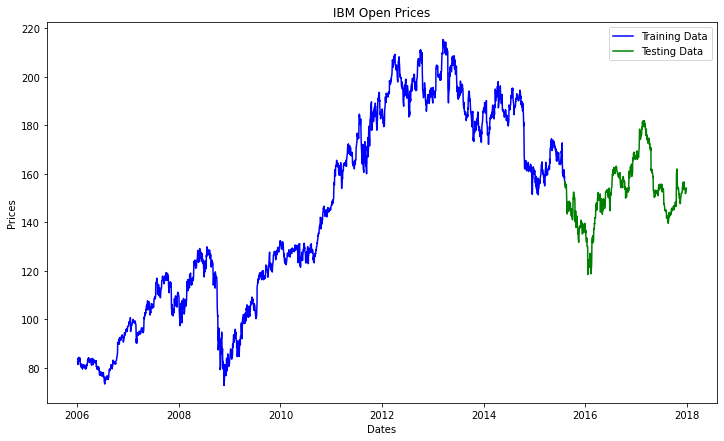

In [4]:
plt.figure(figsize=(12,7))
plt.title('IBM Open Prices')
plt.xlabel('Dates')
plt.ylabel('Prices')
plt.plot(train_series, 'blue', label='Training Data')
plt.plot(test_series, 'green', label='Testing Data')
plt.legend();

### Scaling
As stock prices can vary across a wide range, we scale the data to have zero mean and unit variance.

This is done to ensure that the gradient descent is sooner when learning a deep learning model

### Q12: Use the initialized min-max scaler to scale the prices in train_series

In [5]:
# sc = MinMaxScaler(feature_range=(0,1))
# # START_CODE_HERE
# training_set_scaled = <YOUR CODE HERE>
# # END_CODE_HERE

In [6]:
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range=(0,1))
# START_CODE_HERE
# training_set_scaled = sc.fit_transform(train_data[['Open']])
training_set_scaled = sc.fit_transform(train_series.to_numpy().reshape(-1,1))
# END_CODE_HERE

In [7]:
training_set_scaled.shape

(2415, 1)

In [8]:
training_set_scaled

array([[0.06807347],
       [0.06632081],
       [0.06071228],
       ...,
       [0.60053281],
       [0.60544027],
       [0.59162928]])

### Train Data Preparation

Train data uses the previous 60 days (two months) data to predict the stock price of the next day.
The data is prepared just like a sliding window approach, where
*window_size = 60*

Sample image for sliding window:
![Sliding window](imgs/sliding_window.png)

In [9]:
#1 output and 60 values inputs
# So for each element of training set (output), we have 60 previous training set elements (input)

X_train = []
y_train = []
for i in range(60, len(training_set_scaled)):
    X_train.append(training_set_scaled[i-60:i,0])
    y_train.append(training_set_scaled[i,0])
X_train, y_train = np.array(X_train), np.array(y_train)
X_train.shape, y_train.shape

((2355, 60), (2355,))

#### Reshape X_train

Now we reshape X_train in the format like:

(batch_size, timesteps, input_dim) => (m, features, $x_{i1}$)

The X_train should be now: (2709, 60, 1)

60 features = 60 day sliding window

$x_{i1}$ = 1 data point for each feature and i represents the feature


In [10]:
# Reshaping X_train for efficient modeling
X_train = np.reshape(X_train, (X_train.shape[0],X_train.shape[1], 1))

In [11]:
X_train.shape

(2355, 60, 1)

### LSTM Regression model

We use  [LSTM](https://www.tensorflow.org/api_docs/python/tf/keras/layers/LSTM):
*   units - output dimensions
*   return_sequences is set to True to get all the hidden state vectors information

The model uses 2 LSTM layers followed by a Dense Layer with a single neuron to output regression prediction.

#### Similar Model Architecture (dimensions not exact)

![Similar Model Architecture](imgs/lstm.png)


### Q13: Build the LSTM based forecasting DL Model architecture

Hints:

    - Fill the second LSTM layer using an LSTM cell with 64 units, remember NOT to set return_sequences to True as we are only concerned about passing the last sequence output to the next layer
    - Fill the Output layer with 1 unit
    - Compile the model with mentioned optimizer and loss values

In [12]:
# Let's load the libraries and dependencies for the deep learning model
from sklearn.preprocessing import MinMaxScaler

# %tensorflow_version 1.x
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, GRU, Bidirectional
from tensorflow.keras.optimizers import SGD

In [13]:
# regressor = Sequential()

# # First LSTM layer with Dropout regularisation
# regressor.add(LSTM(units=64, return_sequences=True, input_shape=(X_train.shape[1],1)))
# regressor.add(Dropout(0.2))

# # Second LSTM layer
# <YOUR CODE HERE>

# # The output layer
# <YOUR CODE HERE>

# # Compiling the RNN - optimizer(rmsprop)and loss(mean squared error)
# <YOUR CODE HERE>

# regressor.summary()

In [14]:
regressor = Sequential()

# First LSTM layer with Dropout regularisation
regressor.add(LSTM(units=64, return_sequences=True, input_shape=(X_train.shape[1],1)))
regressor.add(Dropout(0.2))

# Second LSTM layer
regressor.add(LSTM(units=64))

# The output layer
regressor.add(Dense(1))

# Compiling the RNN - optimizer(rmsprop)and loss(mean squared error)
regressor.compile(optimizer='rmsprop', loss='mse')

regressor.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 60, 64)            16896     
_________________________________________________________________
dropout (Dropout)            (None, 60, 64)            0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 64)                33024     
_________________________________________________________________
dense (Dense)                (None, 1)                 65        
Total params: 49,985
Trainable params: 49,985
Non-trainable params: 0
_________________________________________________________________


### Train the model

In [15]:
regressor.fit(X_train,y_train, epochs=15, batch_size=64, validation_split=0.1, shuffle=False)

Epoch 1/15
34/34 [==============================] - 9s 111ms/step - loss: 0.0089 - val_loss: 0.0091
Epoch 2/15
34/34 [==============================] - 3s 76ms/step - loss: 0.0057 - val_loss: 0.0141
Epoch 3/15
34/34 [==============================] - 3s 76ms/step - loss: 0.0055 - val_loss: 0.0059
Epoch 4/15
34/34 [==============================] - 3s 76ms/step - loss: 0.0050 - val_loss: 0.0062
Epoch 5/15
34/34 [==============================] - 3s 76ms/step - loss: 0.0045 - val_loss: 0.0064
Epoch 6/15
34/34 [==============================] - 3s 76ms/step - loss: 0.0041 - val_loss: 0.0061
Epoch 7/15
34/34 [==============================] - 3s 76ms/step - loss: 0.0033 - val_loss: 0.0027
Epoch 8/15
34/34 [==============================] - 3s 76ms/step - loss: 0.0038 - val_loss: 0.0047
Epoch 9/15
34/34 [==============================] - 3s 77ms/step - loss: 0.0034 - val_loss: 0.0051
Epoch 10/15
34/34 [==============================] - 3s 77ms/step - loss: 0.0034 - val_loss: 0.0045
Epoch 11

### Test Data Forecasting

#### Data Preparation:
Lets prepare the test data just like we did with the train data.

Remember to start forecasting on the first day of the test data, we need the last 60 days of train data.

Thus, the following steps have been performed so first 60 entires of test set have 60 previous values from the train dataset

### Q14: Get the last 60 records from train_series

In [16]:
train_last60 = train_series.iloc[-60:]
print(train_last60.shape)
assert train_last60.shape == (60,), ("Oops! There is a data dimension mismatch error. Hint: Slice the last 60 records from train_series")

(60,)


In [17]:
test_series.shape

(604,)

### Q15: Combine both train_last60 and test_series together 

Hint: Check pandas __`concat()`__

In [18]:
new_test_series =  pd.concat([train_last60, test_series])
print(new_test_series.shape)
assert new_test_series.shape == (664,), ("Oops! There is a data dimension mismatch error. Hint: Use pandas concat with the right axis parameter")

(664,)


### Q16: Scale the test dataset (new_test_series) using the trained MinMaxScaler transformer - sc

Hint: Don't fit the scaler again here since it has already been trained

In [25]:
# test_set_scaled = <YOUR CODE HERE>
test_set_scaled = sc.fit_transform(new_test_series.to_numpy().reshape(-1,1))

In [26]:
test_set_scaled.shape

(664, 1)

### Prepare Test dataset Windows of 60  days each

In [27]:
# Preparing X_test and predicting the prices
X_test = []
for i in range(60,len(test_set_scaled)):
    X_test.append(test_set_scaled[i-60:i,0])

X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))
X_test.shape

(604, 60, 1)

### Model Prediction and Reverse Transform of Prices

In [28]:
predicted_stock_price = regressor.predict(X_test)
predicted_stock_price_revtrans = sc.inverse_transform(predicted_stock_price).ravel()
predicted_stock_price_revtrans_series = pd.Series(predicted_stock_price_revtrans)
predicted_stock_price_revtrans_series.index = test_series.index
predicted_stock_price_revtrans_series.shape, test_series.shape

((604,), (604,))

## Model Evaluation

In [31]:
def smape_kun(y_true, y_pred):
    # START_CODE_HERE
    return np.mean((np.abs(y_pred - y_true) * 200 / (np.abs(y_pred) + np.abs(y_true))))
    # END_CODE_HERE

In [32]:
# Evaluating our model
from sklearn.metrics import mean_squared_error

error = mean_squared_error(test_series, predicted_stock_price_revtrans_series)
print('Testing Mean Squared Error: %.3f' % error)
error2 = smape_kun(test_series, predicted_stock_price_revtrans_series)
print('Symmetric Mean absolute percentage error: %.3f' % error2)

Testing Mean Squared Error: 27.700
Symmetric Mean absolute percentage error: 2.960


## Visualizing the results from model predictions

### Visualize train, test and forecasted prices

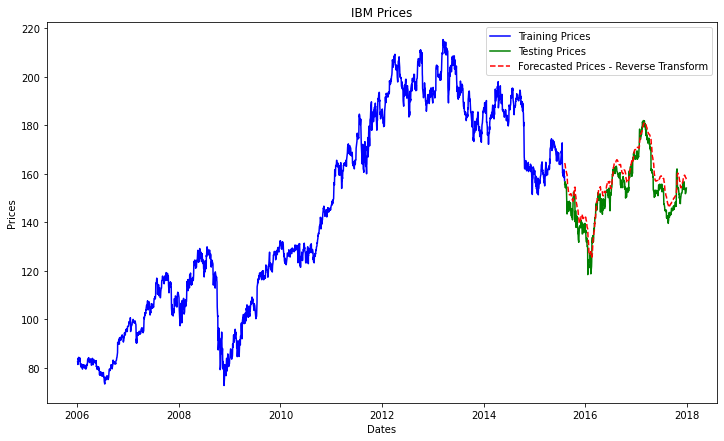

In [33]:
plt.figure(figsize=(12,7))
plt.title('IBM Prices')
plt.xlabel('Dates')
plt.ylabel('Prices')
plt.plot(train_series, color='blue', label='Training Prices')
plt.plot(test_series, color='green', label='Testing Prices')
plt.plot(predicted_stock_price_revtrans_series, color='red', linestyle='--', label='Forecasted Prices - Reverse Transform')
plt.legend();

### Q17: Visualize only test and forecast prices

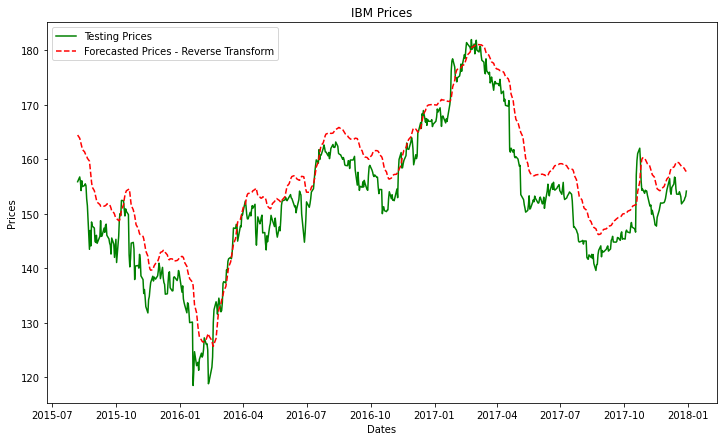

In [34]:
plt.figure(figsize=(12,7))
plt.title('IBM Prices')
plt.xlabel('Dates')
plt.ylabel('Prices')
# plt.plot(train_series, color='blue', label='Training Prices')
plt.plot(test_series, color='green', label='Testing Prices')
plt.plot(predicted_stock_price_revtrans_series, color='red', linestyle='--', label='Forecasted Prices - Reverse Transform')
plt.legend();

# Conclusion

Remember we did a rolling point-based prediction for the ARIMA model where we tried to predict every day's (t) stock price in the test data by using both the training data as well as the previous (n - t) days of test data also to fit the model which gave it such good results vs. the LSTM model where we used 2 months of rolling window price data to predict the next day's price.